In [ ]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patheffects as pe
import matplotlib.colors as mc
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from mycolorpy import colorlist as mcp 
from scipy import interpolate
from astroquery.vizier import Vizier
import colorsys
import numpy as np 
import pandas as pd 
import glob 
import os 


lmc_distance = 50e3 # pc  
lmc_av = 0.38
data_dir = os.getenv("DATADIR")
av = 0.38
extinction_coeff = {
    'Swift_UVM2' : 2.7233599880955124,
    'Bessell_V'  : 1.0333402844940784,
    'GALEX_NUV' : 2.6143147507150744,
    'SDSS_r' : 0.9328640176931913   
}

# Plot Parameters
plt.style.use(data_dir+"bl.mplstyle")
plt.rcParams['legend.fontsize'] = 11


def zams_threshold_plot(ax, zams, blue_band, red_band, switch_mass = 14.87,color = '#E0D4C4', overcolor = '#7E7875',lw=4):
    zams_x = zams[blue_band] - zams[red_band]
    zams_y = zams[blue_band]
    m_diff = np.abs(zams.m - switch_mass)
    zams_y_lim = zams.loc[m_diff == np.min(m_diff), blue_band].values[0]
    
    # Interpolate or you get gaps in the zams line
    f = interpolate.interp1d(zams_x, zams_y)
    zams_x = np.linspace(np.min(zams_x), np.max(zams_x), 1000)
    zams_y = f(zams_x)
    diff = np.abs(zams_y - zams_y_lim)
    zams_y_lim = zams_y[diff == min(diff)][0]
    

    cmap = ListedColormap([color, overcolor])
    norm = BoundaryNorm([np.min(zams_y), zams_y_lim, np.max(zams_y)], cmap.N)
    points = np.array([zams_x, zams_y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=cmap, norm=norm,linewidths=lw)
    lc.set_array(zams_y)
    ax.add_collection(lc)
    ax.set_xlim(np.min(zams_x), np.max(zams_x))
    ax.set_ylim(np.min(zams_y) * 1.1, np.max(zams_y) * 1.1)
    return lc,zams_x,zams_y

def lighten_color(color, amount=0.5):
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])
########
# ZAMS #
########

def Make_Zams(band_1_dir,band_2_dir,folder,band_1_cols,band_2_cols,phot_cols,zams_masses,distance=lmc_distance):
    band_1_dir = band_1_dir + folder 
    band_2_dir = band_2_dir + folder
    filenames = glob.glob(band_1_dir+'*.cmd')
    track_names = [x.split('/')[-1].split('.')[0].split('\\')[-1] for x in filenames]
    row_list = []
    for track in track_names:
        band_1_file = band_1_dir + track + '.track.eep.cmd'
        band_1_df = Open_File(band_1_file)
        band_1_row = band_1_df.loc[band_1_df['phase'] == 0].reset_index(drop=True)
        band_1_row = band_1_row[band_1_row.star_age == band_1_row.star_age.min()]
        band_2_file = band_2_dir + track + '.track.eep.cmd'
        band_2_df = Open_File(band_2_file)
        band_2_row = band_2_df.loc[band_2_df['phase'] == 0].reset_index(drop=True)
        band_2_row = band_2_row[band_2_row.star_age == band_2_row.star_age.min()]
        combined = pd.merge(band_1_row[band_1_cols],band_2_row[band_2_cols],on='star_age')
        row_list.append(combined)
    df = pd.concat(row_list,ignore_index=True)
    # Absolute to Apparant 
    for col in phot_cols:
        df[col] = Absolute_to_Apparent(df[col],distance)
    df['m'] = zams_masses
    return df

##################################
# Mist Models for post-agb stars # 
##################################

# Read in files
def Open_File(file_name):
    # Get the column names
    row = open(file_name, 'r').readlines()
    # It's the last comment in the file so get all the comments
    comments = [x for x in row if '#' in x  ]
    # Split the last row into individual keys, exclude the '#'
    columns = comments[-1].split()[1:]
    # Strip any blank spaces
    columns = [x.strip(' ') for x in columns]
    # Read in as pandas dataframe
    df = pd.read_csv(file_name, comment='#',names = columns,sep=r'\s+')
    return df
# Swift is already in AB but MIST needs to be converted from Vega
def Vega2AB(df,band):
    vega_ab_table = pd.read_csv('https://waps.cfa.harvard.edu/MIST/BC_tables/zeropoints.txt',sep=r'\s+')
    vega_ab = vega_ab_table.loc[vega_ab_table['filter'] == band,'mag(Vega/AB)']
    converted_mag = df[band] + vega_ab.values[0]
    return converted_mag
# We'll also need to convert the absolute magnitudes to apparent magnitudes
def Absolute_to_Apparent(AbsoluteMag,distance):
    return AbsoluteMag + 5 * (np.log10(distance/10))
# 6=postAGB
def Get_AGB(mist_df):
    return mist_df.loc[mist_df['phase'] == 6]
def Get_Track(track,distance=lmc_distance):
    # Open Swift file 
    swift_dir = data_dir + '1_Models/MIST/LMC/Swift/Rotation/'
    swift_file = swift_dir + track + '.track.eep.cmd'
    swift_df = Get_AGB(Open_File(swift_file))
    # Open Bessell file
    bessell_dir = data_dir + '1_Models/MIST/LMC/UBVI/Rotation/'
    bessell_file = bessell_dir + track + '.track.eep.cmd'
    bessell_df = Get_AGB(Open_File(bessell_file))
    # Combine swift row with bessell row
    swift_cols = ['star_age', 'log_Teff', 'log_g', 'log_L', 'Z_surf','phase','Swift_UVW2', 'Swift_UVM2', 'Swift_UVW1']
    bessell_cols = ['Bessell_U','Bessell_B','Bessell_V','Bessell_I']   
    df = pd.concat([swift_df[swift_cols],bessell_df[bessell_cols]], axis=1)
    # Convert bessell to ab
    for band in bessell_cols:
        df[band] = Vega2AB(df,band)
    # Convert to apparent magnitudes
    photometry_cols = ['Swift_UVW2', 'Swift_UVM2', 'Swift_UVW1','Bessell_U','Bessell_B','Bessell_V','Bessell_I']
    for band in photometry_cols:
        df[band] = Absolute_to_Apparent(df[band],distance)
    return df.reset_index(drop=True)
def deredden(mag,band,av=0.38):
    return mag - extinction_coeff[band] * av

def plot_arrow(ax,x,y,blue_band,red_band,offset_x, offset_y, offset_r, color='k',av=0.38):
    # Deredden a point
    red_uv = y
    red_opt = y - x
    print(red_uv,red_opt)
    dered_uv = deredden(red_uv,blue_band,av)
    dered_opt = deredden(red_opt,red_band,av)
    # Get starting coordinate
    arrow_x = red_uv - red_opt
    arrow_y = red_uv
    # Get ending coordinate 
    arrow_dx = (dered_uv - dered_opt) - (red_uv - red_opt) 
    arrow_dy = dered_uv - red_uv
    # Hypotenuse
    hyp_x = arrow_x + arrow_dx
    hyp_y = arrow_y + arrow_dy
    # Adjacent
    adj_x = arrow_x
    adj_y = hyp_y
    # Right Triangle Lengths
    hypot_len = np.sqrt((hyp_x - arrow_x)**2 + (hyp_y - arrow_y)**2)
    adj_len = np.sqrt((adj_x - arrow_x)**2 + (adj_y - arrow_y)**2)
    # Get angle
    alpha = np.arccos(adj_len/hypot_len)
    # Plot arrow
    ax.arrow(arrow_x,arrow_y,arrow_dx,arrow_dy,head_width=0.06, head_length=0.06, fc=color, ec=color,zorder=10)
    ax.annotate(f'A$_v$ = {av}', xy=(arrow_dx/2 + arrow_x, arrow_dy/2 + arrow_y), 
                xytext=(offset_x, offset_y), textcoords='offset points',
                rotation= -90 + np.rad2deg(alpha) + offset_r,
                color=color, family="serif",font="Times New Roman")
       
filenames = glob.glob(data_dir + '1_Models/MIST/LMC/Swift/Rotation/*.cmd')
track_names = [x.split('/')[-1].split('.')[0].split('\\')[-1] for x in filenames]
agb_tracks = {}
for track in track_names:
    track_df = Get_Track(track)
    if track_df.shape[0] != 0: 
        agb_tracks[track] = Get_Track(track)

########
# RAWD #
########
rawd_dir = data_dir + '0_SUMS_Catalogs/OtherBlue/RAWD/'
rawd_files = glob.glob(rawd_dir + '*.csv')
rawd = {'25':pd.read_csv(glob.glob(rawd_dir+'*p25*.csv')[0]),'50':pd.read_csv(glob.glob(rawd_dir+'*p50*.csv')[0]),'100':pd.read_csv(glob.glob(rawd_dir+'*1p00*.csv')[0])}


#############################
# White Dwarf Cooling Track #
#############################
wd_cooling_dir = data_dir + '0_SUMS_Catalogs/OtherBlue/White Dwarf Cooling Sequences/'
wd_cooling_files = glob.glob(wd_cooling_dir + '*.txt')
wd_m = [x.split('seq_')[-1].split('_thick')[0] for x in wd_cooling_files]
wd_tracks = {}
for i,track in enumerate(wd_m):
    wd_tracks[track] = pd.read_csv(wd_cooling_files[i])

def move_wd(track,distance_kpc):
    cols = ['UW2', 'UM2', 'UW1', 'U', 'B','V', 'I']
    # Tracks are at 1kpc by default
    # move to whatever distance you want
    new_track = track.copy()
    for col in cols:
        new_track[col] = track[col] - 5 * (np.log10(1/distance_kpc))
    return new_track

###########
# Quasars #
###########
# Extinction correction for galex and sloan
Galex_coeff_lmc = 2.6143147507150744
g_coeff_lmc = 1.2367195031414489
r_coeff_lmc = 0.9328640176931913

qso = pd.read_csv(data_dir + "0_SUMS_Catalogs/OtherBlue/Quasar/sdss-quasar-crossGALEXGaia-chi.csv")
qso_optical = qso['rmag'] - lmc_av * r_coeff_lmc
qso_uv =  qso['NUVmag'] - lmc_av * Galex_coeff_lmc

#############
# Subdwarfs #
#############
Vizier.ROW_LIMIT = -1
# https://cdsarc.cds.unistra.fr/viz-bin/cat/J/A+A/635/A193#/description
catalog_list = Vizier.find_catalogs('J/A+A/635/A193')
catalogs = Vizier.get_catalogs(catalog_list.keys())
sd = catalogs[0].to_pandas()

# Extinction correction for galex and sloan
sd_optical = sd['rmagSDSS'] - lmc_av * r_coeff_lmc
sd_uv =  sd['NUVmag'] - lmc_av * Galex_coeff_lmc

####################
# ZAMS: Galex/SDSS #
####################

run_nuv_zams = False
if run_nuv_zams:
    nuv = Make_Zams(data_dir + 'MIST/LMC/SDSS/',
                    data_dir + 'MIST/LMC/Galex/',
                    '/',
                    ['star_age', 'log_Teff', 'log_g', 'log_L', 'Z_surf','phase','SDSS_r'],
                    ['star_age','GALEX_FUV', 'GALEX_NUV'],
                    ['SDSS_r','GALEX_FUV','GALEX_NUV'],
                    np.arange(1,25+0.2,0.2))
    nuv.to_csv(data_dir + '1_Models/ZAMS/mist_zams_galex_sdss_lmc_Z-0p37.csv',index=False)
else:
    nuv = pd.read_csv(data_dir + '1_Models/ZAMS/mist_zams_galex_sdss_lmc_Z-0p37.csv')
    
##############
# ZAMS: MIST #
##############

run_mist_zams = False
if run_mist_zams:
    zams_12 = Make_Zams(data_dir + '1_Models/MIST/LMC/UBVI/',
                    data_dir + '1_Models/MIST/LMC/Swift/',
                    'n0p12_1_20_0p2/',
                    ['star_age', 'log_Teff', 'log_g', 'log_L', 'Z_surf','phase','Bessell_U','Bessell_B','Bessell_V','Bessell_I'],
                    ['star_age','Swift_UVW2', 'Swift_UVM2', 'Swift_UVW1'],
                    ['Bessell_U','Bessell_B','Bessell_V','Bessell_I','Swift_UVW2', 'Swift_UVM2', 'Swift_UVW1'],
                    np.arange(1,20+0.2,0.2))
    zams_12.to_csv(data_dir + '1_Models/ZAMS/mist_zams_ubvi_swift_lmc_Z-0p12.csv',index=False)

    zams_37 = Make_Zams(data_dir + '1_Models//MIST/LMC/UBVI/',
                    data_dir + '1_Models/MIST/LMC/Swift/',
                    'n0p37_1_20_0p2/',
                    ['star_age', 'log_Teff', 'log_g', 'log_L', 'Z_surf','phase','Bessell_U','Bessell_B','Bessell_V','Bessell_I'],
                    ['star_age','Swift_UVW2', 'Swift_UVM2', 'Swift_UVW1'],
                    ['Bessell_U','Bessell_B','Bessell_V','Bessell_I','Swift_UVW2', 'Swift_UVM2', 'Swift_UVW1'],
                    np.arange(1,20+0.2,0.2))
    zams_37.to_csv(data_dir + '1_Models/ZAMS/mist_zams_ubvi_swift_lmc_Z-0p37.csv',index=False)

    zams_62 = Make_Zams(data_dir + '1_Models/MIST/LMC/UBVI/',
                    data_dir + '1_Models/MIST/LMC/Swift/',
                    'n0p62_1_20_0p2/',
                    ['star_age', 'log_Teff', 'log_g', 'log_L', 'Z_surf','phase','Bessell_U','Bessell_B','Bessell_V','Bessell_I'],
                    ['star_age','Swift_UVW2', 'Swift_UVM2', 'Swift_UVW1'],
                    ['Bessell_U','Bessell_B','Bessell_V','Bessell_I','Swift_UVW2', 'Swift_UVM2', 'Swift_UVW1'],
                    np.arange(1,20+0.2,0.2))
    zams_62.to_csv(data_dir + '1_Models/ZAMS/mist_zams_ubvi_swift_lmc_Z-0p62.csv',index=False)
else:
    zams_12 = pd.read_csv(data_dir + '1_Models/ZAMS/mist_zams_ubvi_swift_lmc_Z-0p12.csv')
    zams_37 = pd.read_csv(data_dir + '1_Models/ZAMS/mist_zams_ubvi_swift_lmc_Z-0p37.csv')
    zams_62 = pd.read_csv(data_dir + '1_Models/ZAMS/mist_zams_ubvi_swift_lmc_Z-0p62.csv')

In [ ]:
##########
# Simbad #
##########
# Our Catalog
sim = pd.read_csv(data_dir + '0_SUMS_Catalogs/CandidateCatalog/3_stripped_star_candidates.csv')
# sim = pd.read_excel(data_dir + '')
pn = sim[sim.simbad_group == 'PN']
wr = sim[sim.simbad_group == 'WR']
f_wd = sim[sim.simbad_group == 'WhiteDwarf']

# Accreting white dwarf 
ra,dec = 76.340445,	-68.76051
co = SkyCoord(ra=ra, dec=dec, unit='deg')
cos = SkyCoord(ra=sim.ra, dec=sim.dec, unit='deg')
dist = co.separation(cos).arcsecond
wd = sim[dist == np.min(dist)]


In [24]:
simbad_ms = 5
rawd_lw = 3
coolingtrack_lw = 3
lgd2_markerscale = 2


17.25 17.3


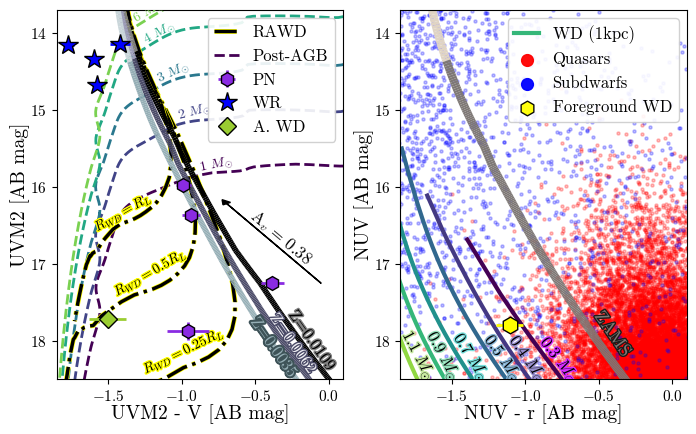

In [136]:
# First panel:
# MIST models for post-AGB stars (highlighting which masses go through this region)
# The RAWD models (see files that have been uploaded).
# (Possible): Different ZAMS models with slightly different (i) rotation (ii) metallicity (iii) reddening. [NB: this one is less clear, we can iterate whether to do this]
# Known objects in your catalog from Simbad: 
# WR, PNe, accreting WD

# Second panel: things related to contamination from either foreground or background objects.
# WD cooling tracks shifted to one or two distances that would place them in your region. 
# Some examples of quasars that fall within this region. [would use NUV-r or NUV-g for this, I have uploaded a file]
# Some examples of galactic subdwarfs that fall within this region [I think you already have this? It would also be NUV - r? We can talk if you don’t have this handy]



f, axes = plt.subplots(1,2, figsize=(7.13,4.5))

# Plot AGB tracks
select_tracks = ['0010000M','0020000M','0030000M','0040000M','0060000M']
label_tracks = [r'1 $M_{\odot}$',r'2 $M_{\odot}$',r'3 $M_{\odot}$',r'4 $M_{\odot}$',r'6 $M_{\odot}$']
agb_colors = mcp.gen_color(cmap="viridis",n=len(select_tracks)+1)
agb_lines = []
for i, track in enumerate(select_tracks):
    agb_line, = axes[0].plot(agb_tracks[track]['Swift_UVM2'] - agb_tracks[track]['Bessell_V'],agb_tracks[track]['Swift_UVM2'],lw=2.,color=agb_colors[i],ls='--')
    agb_lines.append(agb_line)
    
# Plot RAWD
for key in rawd.keys():
    rawd_line, = axes[0].plot(rawd[key]['UM2'] - rawd[key]['V'],rawd[key]['UM2'],lw=2.5,color='black',ls='dashdot',path_effects=[pe.Stroke(linewidth=3.5, foreground='yellow'), pe.Normal()])


# Plot ZAMS
z_colors = mcp.gen_color(cmap="bone",n=4) 
darken_factor = 0.5
zams_lw = 4
z_plot_12 = zams_threshold_plot(axes[0],zams_12, 'Swift_UVM2', 'Bessell_V',lw=zams_lw, overcolor = z_colors[0],color=lighten_color(z_colors[0], amount=darken_factor))
z_plot_37 = zams_threshold_plot(axes[0],zams_37, 'Swift_UVM2', 'Bessell_V',lw=zams_lw, overcolor = z_colors[1],color=lighten_color(z_colors[1], amount=darken_factor))
z_plot_62 = zams_threshold_plot(axes[0],zams_62, 'Swift_UVM2', 'Bessell_V',lw=zams_lw, overcolor = z_colors[2],color=lighten_color(z_colors[2], amount=darken_factor))
z_plot2 = zams_threshold_plot(axes[1], nuv, 'GALEX_NUV', 'SDSS_r',14.8,lw=zams_lw*1.5)

# Plot Simbad crossmatched objects
simbad_colors = {'WR':'navy','PN':'blueviolet','WD':'yellowgreen'}
simbad_edgecolors = {'WR':'b','PN':'indigo','WD':'darkolivegreen'}
simbad_markers = {'WR':'.','PN':'h','WD':'D'}

pn_m = axes[0].errorbar(pn.uvm2_dered - pn.V_dered,pn.uvm2_dered,
                        yerr = pn.uvm2_err,
                        xerr = np.sqrt(pn.uvm2_err**2+pn.e_V**2),
                        color=simbad_colors['PN'],marker=simbad_markers['PN'],ls='None',ms=10,markeredgecolor='k',markeredgewidth=1)
wr_m = axes[0].errorbar(wr.uvm2_dered - wr.V_dered,wr.uvm2_dered,
                        yerr = wr.uvm2_err,
                        xerr = np.sqrt(wr.uvm2_err**2+wr.e_V**2),
                        color='blue',marker='*',ls='None',ms=15,markeredgecolor='k',markeredgewidth=1)
wd_m = axes[0].errorbar(wd.uvm2_dered - wd.V_dered,wd.uvm2_dered,
                        yerr = wd.uvm2_err,
                        xerr = np.sqrt(wd.uvm2_err**2+wd.e_V**2),
                        color=simbad_colors['WD'],marker=simbad_markers['WD'],ls='None',ms=9,markeredgecolor='k',markeredgewidth=1)

# SECOND PANEL 
# WD Cooling Tracks
select_wd = ['020', '030', '040', '050',  '070', '090', '110']
label_wd = [r'0.2 $M_{\odot}$',r'0.3 $M_{\odot}$',r'0.4 $M_{\odot}$',r'0.5 $M_{\odot}$',r'0.7 $M_{\odot}$',r'0.9 $M_{\odot}$',r'1.1 $M_{\odot}$']
select_wd = ['030', '040', '050',  '070', '090', '110']
label_wd = [r'0.3 $M_{\odot}$',r'0.4 $M_{\odot}$',r'0.5 $M_{\odot}$',r'0.7 $M_{\odot}$',r'0.9 $M_{\odot}$',r'1.1 $M_{\odot}$']
wd_colors = mcp.gen_color(cmap="viridis",n=len(select_wd)+1)
move_wd_colors = mcp.gen_color(cmap="plasma",n=len(select_wd))
wd_lines = []; new_wd_lines = []
for i,track in enumerate(select_wd):
    wd_line, = axes[1].plot(wd_tracks[track]['NUV'] - wd_tracks[track]['r_sdss'],
                            wd_tracks[track]['NUV'],lw=coolingtrack_lw,color=wd_colors[i])
    wd_lines.append(wd_line)

    # UNCOMMENT TO SELECT A DISTANCE TO MOVE THE WD TRACKS TO
    # new_track = move_wd(wd_tracks[track],distance_kpc=4.)
    # new_wd_line, = axes[1].plot(new_track['UM2'] - new_track['V'],
    #                 new_track['UM2'],lw=2,color=move_wd_colors[i],ls='--')
    # new_wd_lines.append(new_wd_line)

# Quasars
panel2_markersize = 20
qso_m = axes[1].scatter(qso_uv - qso_optical,qso_uv,marker='.',color='red',s=panel2_markersize,alpha=0.25)
qso_m = axes[1].scatter(0,0,marker='.',color='red',s=18,alpha=0.95)

# Subdwarfs
sd_m = axes[1].scatter(sd_uv - sd_optical,sd_uv,marker='.',color='b',s=panel2_markersize,alpha=0.25)
sd_m = axes[1].scatter(0,0,marker='.',color='b',s=18,alpha=0.95)

# A foreground WD in our sample
f_wd_c = 'yellow'#'hotpink' #simbad_colors['WD']
f_wd_e = 'k' #simbad_edgecolors['WD']
fwd_m = axes[1].errorbar(f_wd.uvm2_dered - f_wd.V_dered,f_wd.uvm2_dered,
                        yerr = f_wd.uvm2_err,
                        xerr = np.sqrt(f_wd.uvm2_err**2+f_wd.e_V**2),
                        color=f_wd_c,marker='h',ls='None',ms=12,markeredgecolor=f_wd_e,markeredgewidth=1,zorder=100)
fwd_m = axes[1].scatter(0,0,marker='h',color=f_wd_c,s=7,alpha=0.95,zorder=100,edgecolor=f_wd_e)


# Axis Limits
[ax.set_ylim(18.5,13.7) for ax in axes]
[ax.set_xlim(-1.85,0.1) for ax in axes]

# Legend
legend = axes[0].legend([rawd_line,agb_lines[0],pn_m,wr_m[0],wd_m[0]],['RAWD','Post-AGB','PN','WR','A. WD'],loc='upper right',facecolor='white', framealpha=0.9,handlelength=1.5,fontsize=12)
legend = axes[1].legend([wd_lines[4],qso_m, sd_m,fwd_m],['WD (1kpc)','Quasars','Subdwarfs','Foreground WD'],loc='upper right',facecolor='white', framealpha=0.9,fontsize=12,markerscale=4,handlelength=1.5)

# Labels
axes[0].set_xlabel('UVM2 - V [AB mag]') 
axes[0].set_ylabel('UVM2 [AB mag]')
axes[1].set_xlabel('NUV - r [AB mag]')
axes[1].set_ylabel('NUV [AB mag]')

# AGB LABELS
agb_fs = 10
axes[0].text(-0.89, 15.79,label_tracks[0],color=agb_colors[0],rotation=12,fontsize=agb_fs)
axes[0].text(-1.04, 15.12,label_tracks[1],color=agb_colors[1],rotation=15,fontsize=agb_fs)
axes[0].text(-1.185, 14.63,label_tracks[2],color=agb_colors[2],rotation=25,fontsize=agb_fs)
axes[0].text(-1.28, 14.13,label_tracks[3],color=agb_colors[3],rotation=28,fontsize=agb_fs)
axes[0].text(-1.35, 13.85,label_tracks[4],color=agb_colors[4],rotation=30,fontsize=agb_fs,clip_on=True);
# WD LABELS
x_adjust = -.09
pe_lw = 2
# t = axes[1].text(-0.6+x_adjust, 18.43,label_wd[0],color='k',rotation=-46)
# t.set_path_effects([pe.Stroke(linewidth=pe_lw, foreground=lighten_color(wd_colors[0], amount=0.6)), pe.Normal()])
t = axes[1].text(-0.93, 18.54,label_wd[1-1],color='k',rotation=-53,clip_on=True) 
t.set_path_effects([pe.Stroke(linewidth=pe_lw, foreground=lighten_color(wd_colors[1-1], amount=0.5)), pe.Normal()])
t =axes[1].text(-1.14, 18.53,label_wd[2-1],color='k',rotation=-55,clip_on=True) 
t.set_path_effects([pe.Stroke(linewidth=pe_lw, foreground=lighten_color(wd_colors[2-1], amount=0.5)), pe.Normal()])
t = axes[1].text(-1.31, 18.52,label_wd[3-1],color='k',rotation=-55,clip_on=True) # 0.5
t.set_path_effects([pe.Stroke(linewidth=pe_lw, foreground=lighten_color(wd_colors[3-1], amount=0.5)), pe.Normal()])
t = axes[1].text(-1.52, 18.51,label_wd[4-1],color='k',rotation=-58,clip_on=True)
t.set_path_effects([pe.Stroke(linewidth=pe_lw, foreground=lighten_color(wd_colors[4-1], amount=0.5)), pe.Normal()])
t = axes[1].text(-1.7, 18.5,label_wd[5-1],color='k',rotation=-62,clip_on=True)
t.set_path_effects([pe.Stroke(linewidth=pe_lw, foreground=lighten_color(wd_colors[5-1], amount=0.5)), pe.Normal()])
t = axes[1].text(-1.87, 18.49,label_wd[6-1],color='k',rotation=-62,clip_on=True)
t.set_path_effects([pe.Stroke(linewidth=pe_lw, foreground=lighten_color(wd_colors[6-1], amount=0.5)), pe.Normal()])

# Accreting white dwarf labels 
path_effects=[pe.Stroke(linewidth=2, foreground='yellow'), pe.Normal()]
raws_fs = 10
wd_x =-0.18
wd_y =0.15
txt = axes[0].text(-1.43+wd_x,16.42+wd_y,r'$R_{WD}=R_L$',rotation=30,fontsize=raws_fs)
txt.set_path_effects(path_effects)
txt = axes[0].text(-1.3+wd_x,17.26+wd_y,r'$R_{WD}=0.5R_L$',rotation=30,fontsize=raws_fs)
txt.set_path_effects(path_effects)
txt = axes[0].text(-1.1+wd_x,18.27+wd_y,r'$R_{WD}=0.25R_L$',rotation=26,zorder=0,fontsize=raws_fs)
txt.set_path_effects(path_effects)

# ZAMS Labels
zx = -0.29
zy = 18.38
z_fs = 16
t = axes[0].annotate(r'Z=0.0109', xy=(zx, zy), xytext=(zx, zy), textcoords='data', ha='left', rotation=-55,color = z_colors[0],weight='bold')
t.set_path_effects([pe.Stroke(linewidth=2, foreground=lighten_color(z_colors[0], amount=0.5)), pe.Normal()])

zx = -0.42
zy = 18.42
t = axes[0].annotate(r'Z=0.0062', xy=(zx, zy), xytext=(zx, zy), textcoords='data', ha='left', rotation=-55,color = lighten_color(z_colors[1], amount=0.1),weight='bold')
t.set_path_effects([pe.Stroke(linewidth=2, foreground=z_colors[1]), pe.Normal()])

zx = -0.55
zy = 18.47
t = axes[0].annotate(r'Z=0.0035', xy=(zx, zy), xytext=(zx, zy), textcoords='data', ha='left', rotation=-55,color = z_colors[2],weight='bold',clip_on=True)
t.set_path_effects([pe.Stroke(linewidth=3, foreground=lighten_color(z_colors[2], amount=2)), pe.Normal()])


zy = 18.2
zx2 = -0.5 - 0.05
t = axes[1].annotate(r'ZAMS', xy=(zx2, zy), xytext=(zx2, zy), textcoords='data', ha='left', rotation=-55,color = '#7E7875',weight='bold',zorder=100,fontsize=13)
t.set_path_effects([pe.Stroke(linewidth=2,foreground=lighten_color('#7E7875', amount=1.7)), pe.Normal()])

plot_arrow(axes[0],x=-0.05,y=17.25,blue_band='Swift_UVM2',red_band='Bessell_V',offset_x=-20, offset_y=-15, offset_r=18, color='k')

plt.tight_layout(w_pad=0.5)
plt.savefig('otherblue.png',bbox_inches='tight')